Rise time: 9.21921921921922 s
Settling time: 9.84984984984985 s


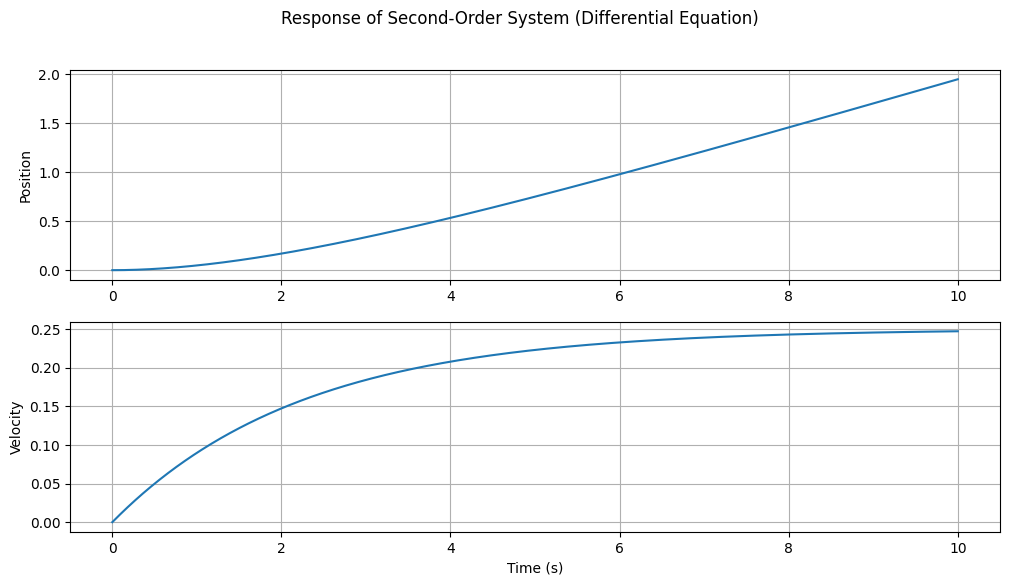

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# System Parameters (adjust these to your system)
a = 9       # coeffiecient of d2y/dt2
b = 4       # coefficient of dy/dt
c = 0       # of y

# Differential Equation Function
def system_dynamics(x, t, u):
    # State variables: x[0] = position, x[1] = velocity
    pos, vel = x

    # Input (e.g., step function)
    # Example: Step input at t=2 seconds
    if t >= 0:
        u = 1.0
    else:
        u = 0.0

    # Differential equations
    dpos_dt = vel
    dvel_dt = (-c/a) * pos - (b/a) * vel + (1/a) * u

    return [dpos_dt, dvel_dt]

# Initial Conditions
x0 = [0.0, 0.0]  # Initial conditions

# Time Vector
t = np.linspace(0, 10, 1000)  # Adjust time range as needed

# Input Signal (Step)
u = np.zeros_like(t)

# Solve the Differential Equation
x = odeint(system_dynamics, x0, t, args=(u,))  # Pass input u

# Extract position and velocity
pos = x[:, 0]
vel = x[:, 1]

# Transient Response Analysis
rise_time_index = np.argmax(pos >= 0.9 * pos[-1])
rise_time = t[rise_time_index]
settling_time_index = np.argmax(np.abs(pos - pos[-1]) < 0.02 * pos[-1])
settling_time = t[settling_time_index]

print(f"Rise time: {rise_time} s")
print(f"Settling time: {settling_time} s")

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, pos, label='Position')
plt.ylabel('Position')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, vel, label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.grid(True)

plt.suptitle('Response of Second-Order System (Differential Equation)')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 38.8 MB/s eta 0:00:00


In [ ]:
!pip install keras

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
# Define MAML model
def get_maml_model(base_model, input_shape):
    # Create a meta-learner model
    meta_model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the meta-model
    meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return meta_model

In [ ]:
# Define MAML training procedure
def maml_train_step(model, support_set, query_set):
    # Training step for one meta-batch
    support_input, support_labels = support_set
    query_input, query_labels = query_set

    # Fine-tune the model on the support set
    model.fit(support_input, support_labels, epochs=5, verbose=0)

    # Evaluate on the query set
    loss, accuracy = model.evaluate(query_input, query_labels, verbose=0)

    return loss, accuracy

In [ ]:
# Load your pre-trained base model (e.g., a CNN)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #delete top layer
base_model.trainable = False  # Freeze the weights of the base model

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your dataset
MOUNT_PATH='/content/drive'
dataset_path = f"{MOUNT_PATH}/MyDrive/FYP_Research_Work/dataset"

In [ ]:
# Read the annotations CSV file
annotations_file = "annotations.csv"
annotations_path = os.path.join(dataset_path, annotations_file)
annotations_df = pd.read_csv(annotations_path)

In [ ]:
# Extract image paths and labels
image_paths = annotations_df['Image_Path'].values
labels = annotations_df['Label'].values

In [ ]:
# Initialize lists to store preprocessed images and corresponding labels
preprocessed_images = []
encoded_labels = []

In [ ]:
# Resize images to a consistent size (e.g., 224x224) and normalize pixel values
target_size = (224, 224)

In [ ]:
mp_model_path = '/absolute/path/to/pose_landmarker.task' #mediapipe model

In [ ]:
#alternative
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=mp_model_path),
    running_mode=VisionRunningMode.IMAGE)

# Load the input image from an image file.
# mp_image = mp.Image.create_from_file('/path/to/image')

# Load the input image from a numpy array.
# mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_image)



In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
for image_path, label in zip(image_paths, labels):
    image_path_full = os.path.join(dataset_path, image_path)
    if os.path.exists(image_path_full):
        image = mp.Image.create_from_file(image_path_full)
        if image is not None:
            detection_result = detector.detect(image)
            if detection_result.segmentation_masks is not None:
              segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
              visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
              # cv2_imshow(visualized_mask)
              image = cv2.cvtColor(visualized_mask, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, target_size)
              image = image / 255.0
              preprocessed_images.append(image)
              encoded_labels.append(label)
        else:
            print(f"Error reading image: {image_path_full}")
    else:
        print(f"Image not found: {image_path_full}")


In [ ]:
#Alternative
for image_path, label in zip(image_paths, labels):
    image_path_full = os.path.join(dataset_path, image_path)
    if os.path.exists(image_path_full):
        image = cv2.imread(image_path_full)

        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image / 255.0
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
            with PoseLandmarker.create_from_options(options) as landmarker:
              # Perform pose landmarking on the provided single image.
              # The pose landmarker must be created with the image mode.
              pose_landmarker_result = landmarker.detect(mp_image)
            preprocessed_images.append(image)
            encoded_labels.append(label)
        else:
            print(f"Error reading image: {image_path_full}")
    else:
        print(f"Image not found: {image_path_full}")


In [ ]:
# Convert lists to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
encoded_labels = np.array(encoded_labels)

In [ ]:
# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(
    preprocessed_images, encoded_labels, test_size=0.2, random_state=42
)

In [ ]:
# Convert labels to one-hot encoding
num_classes = len(np.unique(encoded_labels))
labels_train_onehot = to_categorical(labels_train, num_classes)
labels_test_onehot = to_categorical(labels_test, num_classes)

In [ ]:
# Print information about the dataset
print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {len(images_train)}")
print(f"Number of testing samples: {len(images_test)}")
print(f"Image shape: {preprocessed_images[0].shape}")

Number of classes: 5
Number of training samples: 782
Number of testing samples: 196
Image shape: (224, 224, 3)


In [ ]:
# Assume num_classes is the number of yoga poses
num_classes = len(np.unique(labels))

In [ ]:
# Convert labels to one-hot encoding
labels_onehot = tf.keras.utils.to_categorical(labels, num_classes)

In [ ]:
# Split the dataset into meta-training and meta-testing sets
meta_train_data = (images_train, labels_train_onehot)
meta_test_data = (images_test, labels_test_onehot)

In [ ]:
# Create a MAML model
input_shape = images_train[0].shape
maml_model = get_maml_model(base_model, input_shape)

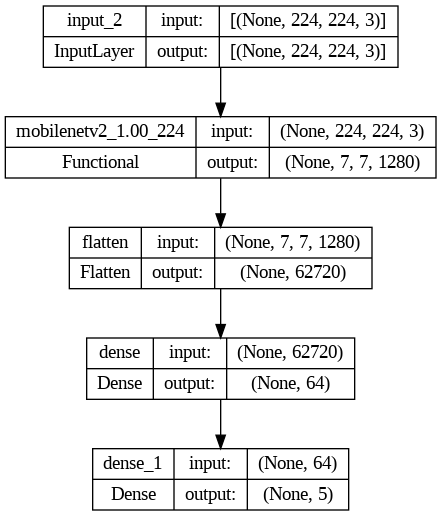

In [ ]:
plot_model(maml_model, to_file='model_plot_keypoint_maml_model_5_poses.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Number of meta-batches and meta-iterations
num_meta_batches = 100
num_meta_iterations = 5

In [ ]:
import random

def sample_meta_batch(meta_data, batch_size=5):
    # meta_data is a tuple containing images and labels for the meta-training set
    images, labels = meta_data

    # Randomly sample a meta-batch
    sampled_indices = random.sample(range(len(images)), batch_size)
    sampled_images = images[sampled_indices]
    sampled_labels = labels[sampled_indices]

    return sampled_images, sampled_labels


In [ ]:
# Meta-training loop
for meta_iteration in range(num_meta_iterations):
    for meta_batch in range(num_meta_batches):
        # Sample a random meta-batch from the meta-training set
        support_set = sample_meta_batch(meta_train_data)
        query_set = sample_meta_batch(meta_train_data)

        # Perform a meta-training step
        loss, accuracy = maml_train_step(maml_model, support_set, query_set)

        print(f'Meta-Iteration: {meta_iteration + 1}, Meta-Batch: {meta_batch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Meta-Iteration: 1, Meta-Batch: 1, Loss: 25.1157, Accuracy: 0.2000
Meta-Iteration: 1, Meta-Batch: 2, Loss: 15.6227, Accuracy: 0.8000
Meta-Iteration: 1, Meta-Batch: 3, Loss: 46.9856, Accuracy: 0.2000
Meta-Iteration: 1, Meta-Batch: 4, Loss: 1.9702, Accuracy: 0.8000
Meta-Iteration: 1, Meta-Batch: 5, Loss: 14.4811, Accuracy: 0.4000
Meta-Iteration: 1, Meta-Batch: 6, Loss: 0.0000, Accuracy: 1.0000
Meta-Iteration: 1, Meta-Batch: 7, Loss: 16.4359, Accuracy: 0.6000
Meta-Iteration: 1, Meta-Batch: 8, Loss: 14.6612, Accuracy: 0.6000
Meta-Iteration: 1, Meta-Batch: 9, Loss: 4.5635, Accuracy: 0.8000
Meta-Iteration: 1, Meta-Batch: 10, Loss: 13.8896, Accuracy: 0.6000
Meta-Iteration: 1, Meta-Batch: 11, Loss: 6.5973, Accuracy: 0.8000
Meta-Iteration: 1, Meta-Batch: 12, Loss: 3.6463, Accuracy: 0.8000
Meta-Iteration: 1, Meta-Batch: 13, Loss: 0.0015, Accuracy: 1.0000
Meta-Iteration: 1, Meta-Batch: 14, Loss: 7.5230, Accuracy: 0.6000
Meta-Iteration: 1, Meta-Batch: 15, Loss: 29.1310, Accuracy: 0.4000
Meta-Iterat

In [ ]:
# Evaluate the meta-trained model on the meta-test set
meta_test_loss, meta_test_accuracy = maml_model.evaluate(meta_test_data[0], meta_test_data[1])
print(f'Meta-Test Loss: {meta_test_loss:.4f}, Meta-Test Accuracy: {meta_test_accuracy:.4f}')

7/7 [==============================] - 8s 1s/step - loss: 0.1379 - accuracy: 0.9745
Meta-Test Loss: 0.1379, Meta-Test Accuracy: 0.9745


In [ ]:
image_path_full = f"{MOUNT_PATH}/MyDrive/FYP_Research_Work/dataset/Warrior-II-Pose.jpg"
print(dataset_path)
if os.path.exists(image_path_full):
    image = cv2.imread(image_path_full)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image / 255.0
        new_image = np.reshape(image, (1, 224, 224, 3))

    else:
        print(f"Error reading image: {image_path_full}")
else:
    print(f"Image not found: {image_path_full}")


/content/drive/MyDrive/FYP_Research_Work/dataset


In [ ]:
pred = base_model.predict(new_image)
pred_cls = np.argmax(pred)
print(f"Base model prediction: {pred}")

In [ ]:
# Make a prediction using the trained model
prediction = maml_model.predict(new_image)

# Get the predicted class (pose)
predicted_class = np.argmax(prediction)

print(f"Predicted Pose Class: {predicted_class}")

1/1 [==============================] - 1s 956ms/step
Predicted Pose Class: 1


In [ ]:
np.argmax(maml_model.predict(new_image))

In [ ]:
model_path = f"{MOUNT_PATH}/MyDrive/FYP_Research_Work/FewShotYogaPoseClassifier/few_shot_pose_classifier_5_1_acc_97.h5"

In [ ]:
# Save the trained model

maml_model.save(model_path)
print("Trained model saved.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model saved.


In [ ]:
poses = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_path = f"{MOUNT_PATH}/MyDrive/FYP_Research_Work/FewShotYogaPoseClassifier/few_shot_pose_classifier_5_2.h5"

In [ ]:
# Load the trained few-shot learning model
trained_model_1 = load_model(model_1_path)

In [ ]:
# Load the trained few-shot learning model
trained_model_2 = load_model(model_path)

In [ ]:
pred = trained_model_1.predict(new_image)

print("The detected pose: ", poses[np.argmax(pred)])

1/1 [==============================] - 1s 1s/step
The detected pose:  Warrior2


In [ ]:
print(pred)

[[0.000000e+00 3.449251e-34 0.000000e+00 5.974712e-09 1.000000e+00]]


In [ ]:
pred_2 = trained_model_2.predict(new_image)

np.argmax(pred_2)

1/1 [==============================] - 0s 53ms/step


0

In [ ]:
print("The detected pose: ", poses[np.argmax(pred_2)])

The detected pose:  Downdog
